In [2]:
# https://towardsdatascience.com/building-a-bayesian-logistic-regression-with-python-and-pymc3-4dd463bbb16

In [ ]:
# we will explore using Bayesian Logistic Regression in order to predict whether or not a customer will subscribe a term deposit after the marketing campaign the bank performed.

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import matplotlib.lines as mlines
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
import theano
import theano.tensor as tt
import itertools
from IPython.core.pylabtools import figsize
pd.set_option('display.max_columns', 30)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [10]:
df = pd.read_csv('bank-full.csv')
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [ ]:
# display the distribution of a numerical variable across different categories.
# Nothing particularly interesting from the plots below.

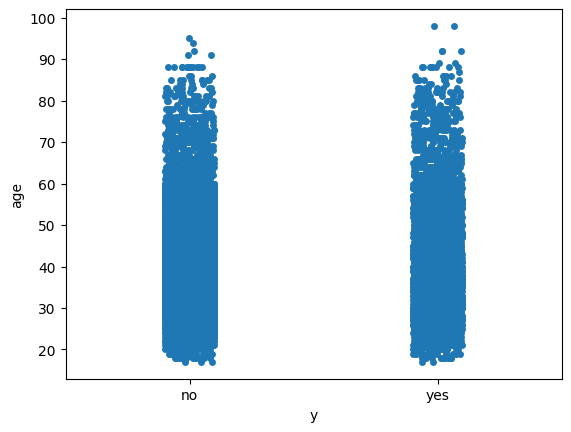

In [13]:
sns.stripplot(x="y", y="age", data=df, jitter=True)
plt.show()

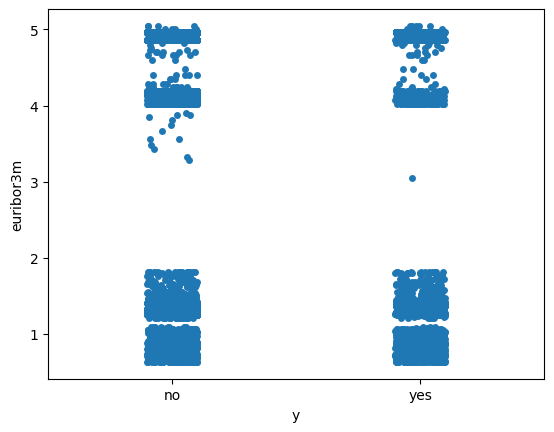

In [14]:
sns.stripplot(x="y", y="euribor3m", data=df, jitter=True)
plt.show();

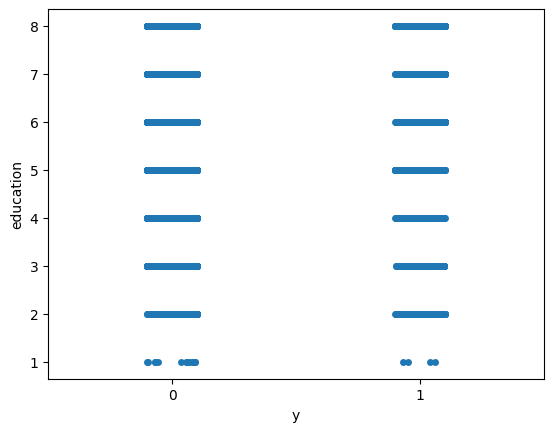

In [23]:
sns.stripplot(x="y", y="education", data=df, jitter=True)
plt.show();

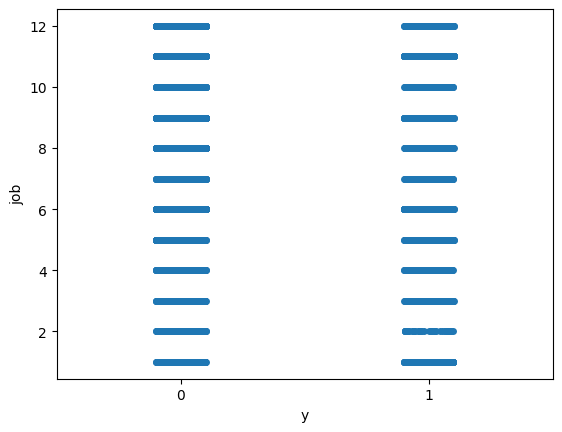

In [24]:
sns.stripplot(x="y", y="job", data=df, jitter=True)
plt.show();

In [15]:
# it could be done with label encoding

def replace_education(education):
    """
    This function codes the highest education attained.
    """
    if education == 'university.degree':
        return 8
    elif education == 'professional.course':
        return 7
    elif education == 'high.school':
        return 6
    elif education == 'basic.9y':
        return 5
    elif education == 'basic.6y':
        return 4
    elif education =='basic.4y':
        return 3
    elif education == 'unknown':
        return 2
    elif education == 'illiterate':
        return 1
    
def replace_job(job):
    """
    This function codes the highest job earned.
    """
    if job == 'management':
        return 12
    elif job == 'admin.':
        return 11
    elif job == 'entrepreneur':
        return 10
    elif job == 'technician':
        return 9
    elif job == 'services':
        return 8
    elif job == 'self-employed':
        return 7
    elif job == 'blue-collar':
        return 6
    elif job == 'retired':
        return 5
    elif job == 'housemaid':
        return 4
    elif job == 'unemployed':
        return 3
    elif job == 'unknown':
        return 2
    elif job == 'student':
        return 1
    
def replace_marital(marital):
    if marital == 'married':
        return 4
    elif marital == 'single':
        return 3
    elif marital == 'divorced':
        return 2
    elif marital == 'unknown':
        return 1
    
def replace_default(default):
    if default == 'no':
        return 0
    elif default == 'yes':
        return 1
    elif default == 'unknown':
        return 2
    
def replace_housing(housing):
    if housing == 'no':
        return 0
    elif housing == 'yes':
        return 1
    elif housing == 'unknown':
        return 2

def replace_loan(loan):
    if loan == 'no':
        return 0
    elif loan == 'yes':
        return 1
    elif loan == 'unknown':
        return 2
    
def replace_contact(contact):
    if contact == 'cellular':
        return 1
    elif contact == 'telephone':
        return 2
    
def replace_poutcome(poutcome):
    if poutcome == 'failure':
        return 0
    elif poutcome == 'success':
        return 1
    elif poutcome == 'nonexistent':
        return 2

df['education'] = df['education'].apply(lambda x: replace_education(x))
df['job'] = df['job'].apply(lambda x: replace_job(x))
df['marital'] = df['marital'].apply(lambda x: replace_marital(x))
df['default'] = df['default'].apply(lambda x: replace_default(x))
df['housing'] = df['housing'].apply(lambda x: replace_housing(x))
df['loan'] = df['loan'].apply(lambda x: replace_loan(x))
df['contact'] = df['contact'].apply(lambda x: replace_contact(x))
df['poutcome'] = df['poutcome'].apply(lambda x: replace_poutcome(x))

look_up = {'aug': 8, 'nov': 11, 'jun': 6, 'apr': 4, 'jul': 7,
            'may': 5, 'oct': 10, 'mar': 3, 'sep': 9, 'dec': 12}
df['month'] = df['month'].apply(lambda x: look_up[x])

look_up = {'thu': 4, 'fri': 5, 'tue': 2, 'mon': 1, 'wed': 3}
df['day_of_week'] = df['day_of_week'].apply(lambda x: look_up[x])

In [16]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,4,4,3,0,0,0,2,5,1,261,1,999,0,2,1.1,93.994,-36.4,4.857,5191.0,no
1,57,8,4,6,2,0,0,2,5,1,149,1,999,0,2,1.1,93.994,-36.4,4.857,5191.0,no
2,37,8,4,6,0,1,0,2,5,1,226,1,999,0,2,1.1,93.994,-36.4,4.857,5191.0,no
3,40,11,4,4,0,0,0,2,5,1,151,1,999,0,2,1.1,93.994,-36.4,4.857,5191.0,no
4,56,8,4,6,0,0,1,2,5,1,307,1,999,0,2,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,5,4,7,0,1,0,1,11,5,334,1,999,0,2,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,6,4,7,0,0,0,1,11,5,383,1,999,0,2,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,5,4,8,0,1,0,1,11,5,189,2,999,0,2,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,9,4,7,0,0,0,1,11,5,442,1,999,0,2,-1.1,94.767,-50.8,1.028,4963.6,yes


In [21]:
df.y[df.y=='yes'] = 1
df.y[df.y=='no'] = 0

In [22]:
outcome = df['y']
data = df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'euribor3m']]
data['outcome'] = outcome
data.corr()['outcome'].sort_values(ascending=False)

outcome        1.000000
duration       0.405274
previous       0.230181
month          0.037187
education      0.035848
age            0.030399
day_of_week    0.010051
housing        0.009552
loan          -0.005038
job           -0.023020
marital       -0.026302
campaign      -0.066357
default       -0.099324
poutcome      -0.122089
contact       -0.144773
euribor3m     -0.307771
pdays         -0.324914
Name: outcome, dtype: float64

In [28]:
# We are going to begin with the simplest possible logistic model, using just one independent variable or feature, the duration.

In [27]:

y_simple = data['outcome'] # extracting the outcome variable (the variable we want to predict) from the data.
x_n = 'duration' # setting the predictor variable (the variable we are using to make the prediction) to be ‘duration’.
x_0 = data[x_n].values # extracting the values of the predictor variable from the data.
x_c = x_0 - x_0.mean() # centering the predictor variable by subtracting its mean. This is a common preprocessing step in statistical modeling.

with pm.Model() as model_simple: # creating a new PyMC3 model. All the code inside this block is defining the model.
    # defining the prior distributions for the intercept (α) and the slope (β) of the logistic regression model. Both are assumed to follow a Normal distribution with mean 0 and standard deviation 10.
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    
    # μ is logit (the input to the logistic function) and θ is the output of the logistic function (sigmoid)
    μ = α + pm.math.dot(x_c, β) # defining the linear predictor (μ) of the logistic regression model. It’s a linear combination of the predictor variable and the parameters.
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ)) # applying the sigmoid function to the linear predictor to get the probability of the positive class (θ).
    bd = pm.Deterministic('bd', -α/β) # calculating the decision boundary (bd) of the logistic regression model. It's the decision boundary in the input space (the space of predictor variables), not the probability space. It’s the value of the predictor variable at which the predicted probability is 0.5. In other words, it’s the value of x for which θ (the output of the logistic function) equals 0.5.
    
    y_1 = pm.Bernoulli('y_1', p=θ, observed=y_simple) # defining the likelihood of the data. It’s assumed to follow a Bernoulli distribution with probability θ.

    trace_simple = pm.sample(1000, tune=1000, cores=1) # performing the actual Bayesian inference. It’s drawing 1000 samples from the posterior distribution of the model parameters, after a tuning phase of 1000 iterations. The cores=1 argument means that the sampling is done sequentially, not in parallel.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 39995 seconds.


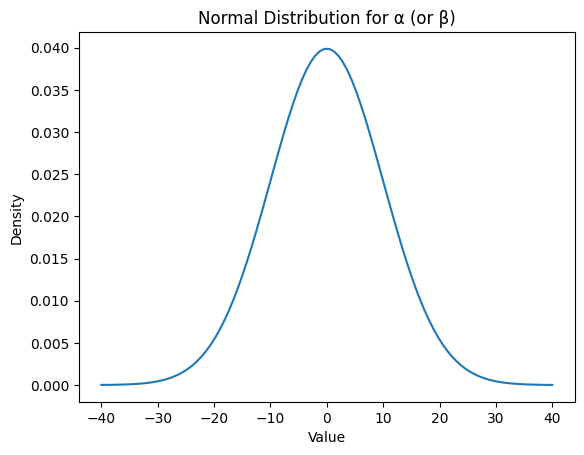

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

mu = 0
sd = 10
x = np.linspace(mu - 4*sd, mu + 4*sd, 100) # It’s a common practice when plotting a normal distribution to include values within a range of +/- 4 standard deviations around the mean.
plt.plot(x, stats.norm.pdf(x, mu, sd))
plt.title('Normal Distribution for α (or β)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

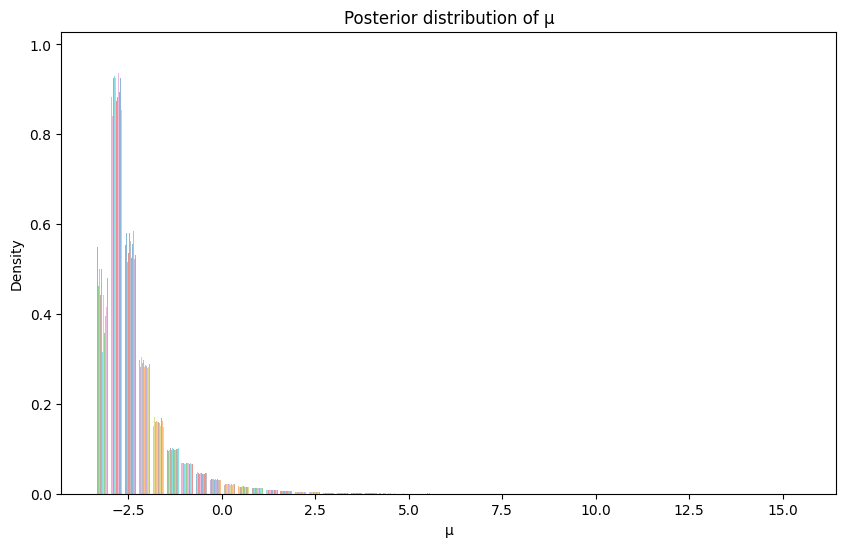

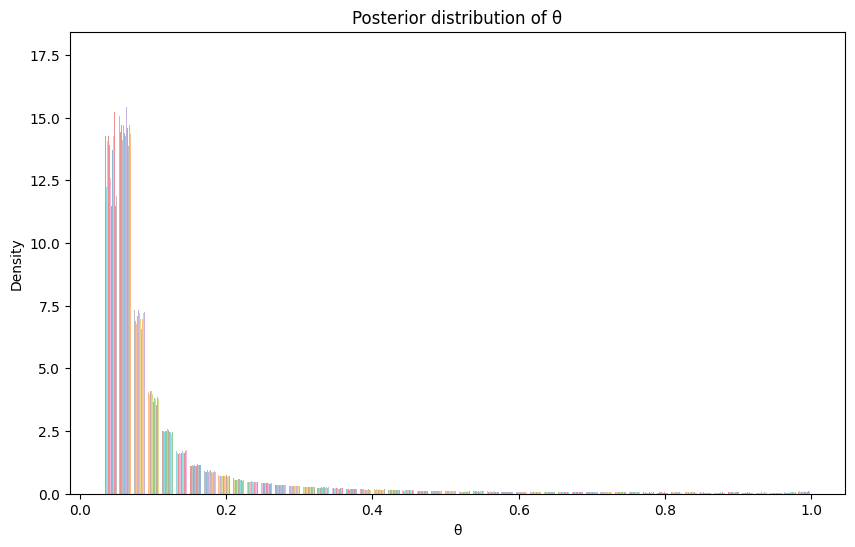

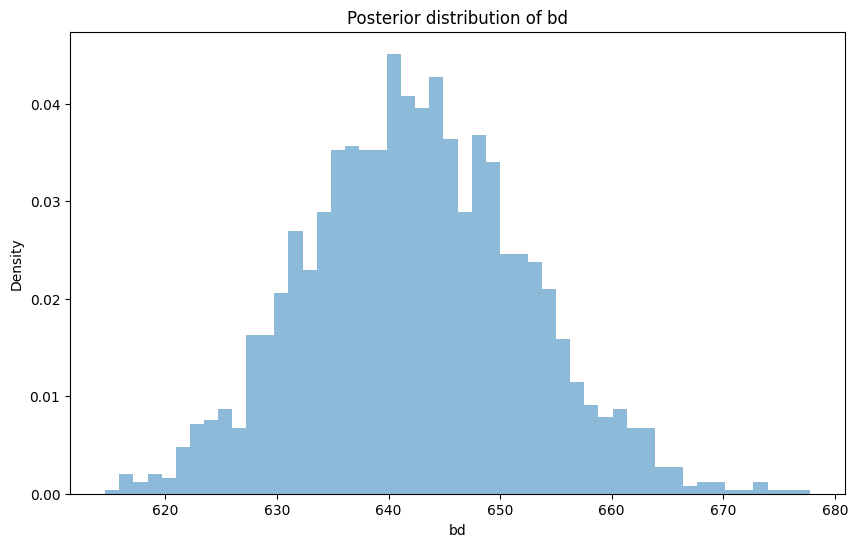

In [56]:
import matplotlib.pyplot as plt

# Generate values for μ, θ, and bd
α_samples = trace_simple['α']
β_samples = trace_simple['β']

x_c_repeat = np.repeat(x_c[:, None], len(β_samples), axis=1)

μ_samples = α_samples + β_samples * x_c_repeat #logit function

θ_samples = 1 / (1 + np.exp(-μ_samples)) #logistic function
bd_samples = -α_samples / β_samples # input space decision boundary

# Plot μ
plt.figure(figsize=(10, 6))
plt.hist(μ_samples, bins=50, density=True, alpha=0.5)
plt.title('Posterior distribution of μ')
plt.xlabel('μ')
plt.ylabel('Density')
plt.show()

# Plot θ
plt.figure(figsize=(10, 6))
plt.hist(θ_samples, bins=50, density=True, alpha=0.5)
plt.title('Posterior distribution of θ')
plt.xlabel('θ')
plt.ylabel('Density')
plt.show()

# Plot bd
plt.figure(figsize=(10, 6))
plt.hist(bd_samples, bins=50, density=True, alpha=0.5)
plt.title('Posterior distribution of bd')
plt.xlabel('bd')
plt.ylabel('Density')
plt.show()

In [60]:
α_samples.shape, β_samples.shape, x_c.shape, x_c_repeat.shape

((2000,), (2000,), (41188,), (41188, 2000))

In [63]:
μ_samples.shape, θ_samples.shape, bd_samples.shape

((41188, 2000), (41188, 2000), (2000,))

In [78]:
trace_simple, trace_simple[0], len(trace_simple), trace_simple[0]['θ'].shape

(<MultiTrace: 2 chains, 1000 iterations, 4 variables>,
 {'α': -2.3300078282756806,
  'β': 0.003535184660533292,
  'θ': array([0.08944667, 0.06201542, 0.07986804, ..., 0.07076855, 0.15702379,
         0.08331129]),
  'bd': 659.0908402290343},
 1000,
 (41188,))

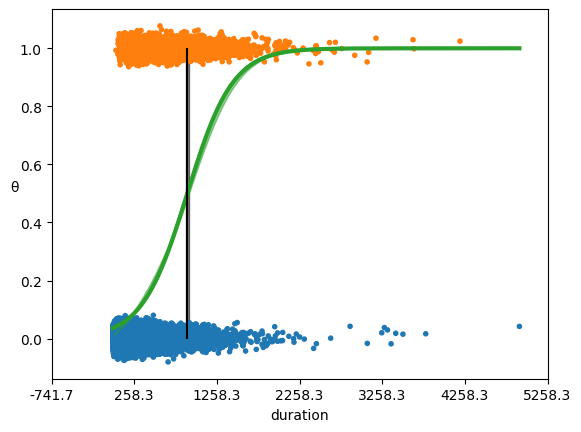

In [81]:

# The resulting plot shows the observed data, the mean and HDI of the predicted probabilities θ (model prediction), and the mean and HDI of the decision boundary bd. This visualization can help you understand the fit of the logistic regression model to the data.
# HPD (Highest Posterior Density) or Highest Density Interval (HDI) is a measure of credibility (analogue to confidence): it represents the range of values that are most credible given the data.

theta = trace_simple['θ'].mean(axis=0) # calculates the mean of the θ values over the MCMC samples. The result is an array of mean θ values for each value of x_c
idx = np.argsort(x_c) # gets the indices that would sort x_c. This is used to plot x_c and theta in increasing order of x_c.
plt.plot(x_c[idx], theta[idx], color='C2', lw=3) # plots the mean θ values against x_c. The points are plotted in increasing order of x_c

plt.vlines(trace_simple['bd'].mean(), 0, 1, color='k') # adds a vertical line to the plot at the mean of the decision boundary bd.
bd_hpd = az.hdi(trace_simple['bd']) # calculates the Highest Posterior Density of the boundary, calculated as the Highest Density Interval (HDI) of bd.
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5) # adds a shaded area to the plot between the lower and upper limits of the HDI of bd.

plt.scatter(x_c, np.random.normal(y_simple, 0.02),
            marker='.', color=[f'C{x}' for x in y_simple]) # adds a scatter plot of the observed data to the plot. The y-values are jittered (randomly displaced) to avoid overplotting.
az.plot_hdi(x_c, trace_simple['θ'], color='C2') # adds a plot of the HDI of θ against x_c to the plot.
plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1));

In [ ]:
# The above plot shows non subscription versus subscription (y = 0, y = 1). The S-shaped (green) line is the mean value of θ. This line can be interpreted as the probability of a subscription, given that we know that the last time contact duration(the value of the duration).The boundary decision is represented as a (black) vertical line. According to the boundary decision, the values of duration to the left correspond to y = 0 (non subscription), and the values to the right to y = 1 (subscription).

In [107]:
# We summarize the inferred parameters values for easier analysis of the results and check how well the model did:

# The parameters α and β in the model are very narrowly defined, as indicated by their small standard deviations (sd) and the narrow range of their Highest Posterior Density Intervals (hpd_3% and hpd_97%). This means that there is a high degree of certainty about the values of these parameters given the data and the model.

# This is expected when you are fitting a binary fitted line to a perfectly aligned set of points. In such a case, the data provides very strong evidence about the location of the line, so the posterior distributions of the line parameters are very concentrated around their most probable values.

# Here’s a bit more detail:

# The r_hat values are close to 1, indicating good convergence for the Markov chain Monte Carlo (MCMC) sampling, which means the samples drawn from the posterior distribution should be a good representation of the actual posterior.

# The ess_mean, ess_sd, ess_bulk, and ess_tail values are the effective sample sizes for the mean, standard deviation, bulk, and tail, respectively. They are measures of the number of “effectively independent” draws from the posterior distribution that the MCMC algorithm has produced. Larger values are better, indicating more precise estimates of these quantities.

az.summary(trace_simple, var_names=['α', 'β'])

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-2.347,0.019,-2.379,-2.305,0.0,0.0,1514.0,1098.0,1.0
β,0.004,0.000,0.004,0.004,0.0,0.0,1585.0,1314.0,1.0


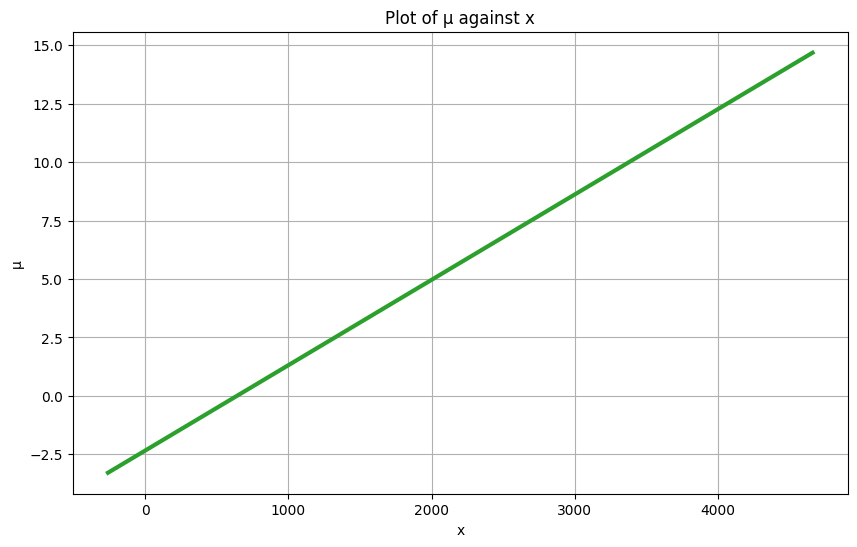

In [108]:
# α is the intercept of the line. It represents the expected value of μ when all predictor variables are zero. In your case, α is around -2.347.
# β is the slope of the line. It represents the change in the expected value of μ for each one-unit change in the predictor variable. In your case, β is around 0.004.

# Calculate μ for a range of x values
x_values = np.linspace(min(x_c), max(x_c), 100)
μ_values = α_samples.mean() + β_samples.mean() * x_values

# Plot μ against x
plt.figure(figsize=(10, 6))
plt.plot(x_values, μ_values, color='C2', lw=3)
plt.xlabel('x')
plt.ylabel('μ')
plt.title('Plot of μ against x')
plt.grid(True)
plt.show()

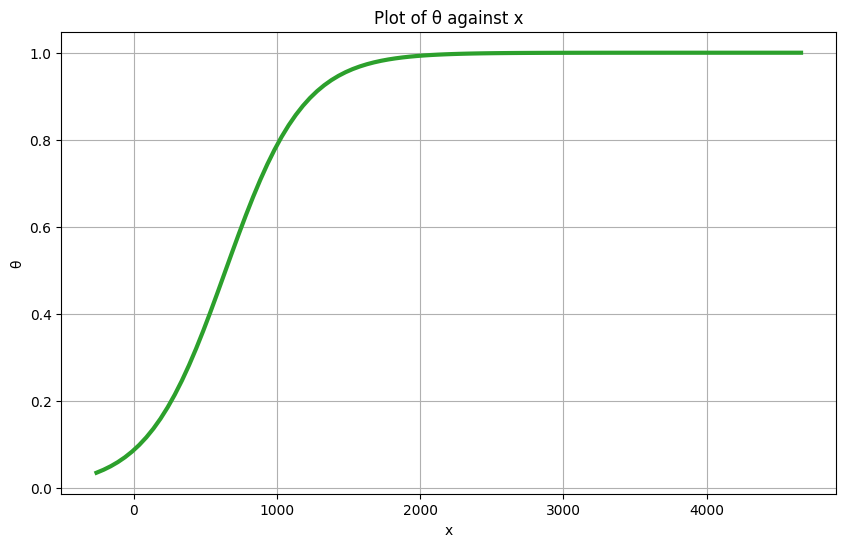

In [109]:
# μ is the logit of the probability θ, so the y-axis of this plot is on the logit scale. If you want to plot the probability θ instead, you can apply the logistic function to μ_values:

θ_values = 1 / (1 + np.exp(-μ_values))

plt.figure(figsize=(10, 6))
plt.plot(x_values, θ_values, color='C2', lw=3)
plt.xlabel('x')
plt.ylabel('θ')
plt.title('Plot of θ against x')
plt.grid(True)
plt.show()

In [118]:
print(np.unique(preds))  # Should only contain 0 and 1
print(np.isnan(preds).any())  # Should be False
print(preds.shape == data['outcome'].shape)  # Should be True

[0 1]
False
True


In [119]:
print(np.unique(data['outcome']))  # Should only contain 0 and 1

data['outcome'] = pd.to_numeric(data['outcome'], errors='coerce')

print(np.isnan(data['outcome']).any())  # Should be False

[0 1]
False


In [ ]:
# The array θ in your trace_simple object does indeed represent samples from the posterior distribution of θ. However, these are not the same as posterior predictive samples.

# Here’s the difference:

# The posterior samples (e.g., trace_simple['θ']) are samples of the model parameters (θ in this case) given the observed data. These samples represent our updated beliefs about the parameters after observing the data.

# The posterior predictive samples (obtained from pm.sample_posterior_predictive) are samples of new data given the observed data. These samples represent predictions for new observations given the observed data and our updated beliefs about the parameters.

# In other words, trace_simple['θ'] represents what we’ve learned about θ from the data, while pm.sample_posterior_predictive(trace_simple, model=model_simple, samples=500) represents what we might expect to see if we were to collect new data under the same conditions.

# So, while trace_simple['θ'] gives you information about the parameter θ, it doesn’t directly give you predictive samples for new data. For that, you need to use pm.sample_posterior_predictive.

In [120]:
# Let’s run a posterior predictive check to explore how well our model captures the data. We can let PyMC3 do the hard work of sampling from the posterior for us:

ppc = pm.sample_posterior_predictive(trace_simple, model=model_simple, samples=500)
preds = np.rint(ppc['y_1'].mean(axis=0)).astype('int')

print('Accuracy of the simplest model:', accuracy_score(preds, data['outcome']))
print('f1 score of the simplest model:', f1_score(preds, data['outcome']))

Accuracy of the simplest model: 0.8932698844323589
f1 score of the simplest model: 0.2586846543001687


In [128]:
ppc['y_1'].shape

(500, 41188)

In [ ]:
# In the line of code pm.sample_posterior_predictive(trace_simple, model=model_simple, samples=500), there isn’t any new data being explicitly provided. Instead, this function is generating new “predicted” data based on the model and the posterior distribution of the parameters.

# Here’s how it works:

# The model (model_simple) and the posterior samples (trace_simple) encapsulate everything we’ve learned from the observed data about the underlying process that generates the data.
# pm.sample_posterior_predictive uses this information to simulate what new data we might observe if we were to repeat the experiment or data collection process. It does this by drawing parameter values from the posterior distribution (trace_simple) and then using those parameter values to generate data according to the model (model_simple).
# The samples=500 argument means we’re repeating this process 500 times, so the function returns 500 sets of simulated data. Each set of simulated data is a “posterior predictive sample”.

# So, while there isn’t any explicit new data being provided to the function, the function is generating new data as output. This new data represents what we might expect to observe given the model and the posterior distribution of the parameters.

In [133]:
outcome.shape, preds.shape

((41188,), (41188,))

In [129]:
outcome.value_counts()

y
0    36548
1     4640
Name: count, dtype: int64

In [138]:
pd.Series(preds).value_counts()

0    39898
1     1290
Name: count, dtype: int64

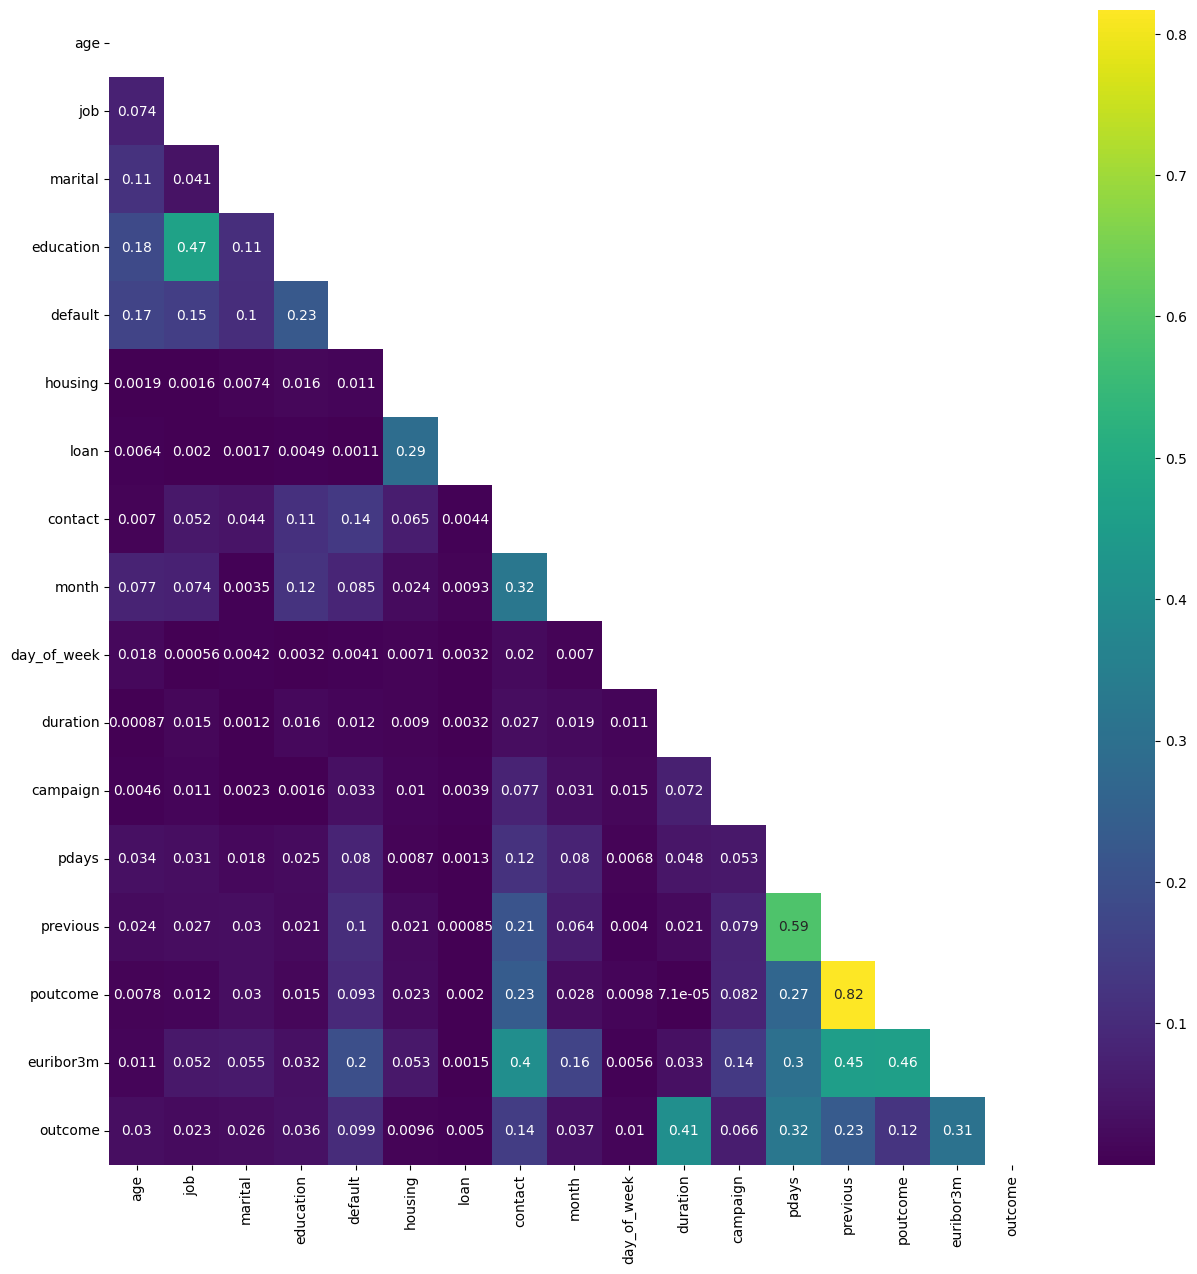

In [139]:
# We plot a heat map to show the correlations between each variables.

plt.figure(figsize=(15, 15))
corr = data.corr() 
mask = np.tri(*corr.shape).T 
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis');

In [ ]:
# poutcome & previous have a high correlation, we can simply remove one of them, I decide to remove poutcome.
# There are not many strong correlations with the outcome variable. The highest positive correlation is 0.41.

In [ ]:
# Define logistic regression model using PyMC3 GLM method with multiple independent variables
# We assume that the probability of a subscription outcome is a function of age, job, marital, education, default, housing, loan, contact, month, day of week, duration, campaign, pdays, previous and euribor3m. We need to specify a prior and a likelihood in order to draw samples from the posterior.

# The interpretation formula is as follows:
# logit = β0 + β1(age) + β2(age)2 + β3(job) + β4(marital) + β5(education) + β6(default) + β7(housing) + β8(loan) + β9(contact) + β10(month) + β11(day_of_week) + β12(duration) + β13(campaign) + β14(campaign) + β15(pdays) + β16(previous) + β17(poutcome) + β18(euribor3m) and y = 1 if outcome is yes and y = 0 otherwise.

# The log odds can then be converted to a probability of the output (logit function --> logistic function - sigmoid)

# For our problem, we are interested in finding the probability a customer will subscribe a term deposit given all the activities: p(subscription/features)



In [147]:
# # With the math out of the way we can get back to the data. PyMC3 has a module glm for defining models using a patsy-style formula syntax. This seems really useful, especially for defining models in fewer lines of code.
# # We use PyMC3 to draw samples from the posterior. The sampling algorithm used is NUTS, in which parameters are tuned automatically.

# # We will use all these 18 variables and create the model using the formula defined above. 
# # We will also scale age by 10, ad add age_2, which helps with model convergence.

# data['age'] = data['age'] / 10
# data['age2'] = np.square(data['age'])

# with pm.Model() as logistic_model:
#     pm.glm.GLM.from_formula('outcome ~ age + age2 + job + marital + education + default + housing + loan + contact + month + day_of_week + duration + campaign + pdays + previous + euribor3m', data, family = pm.glm.families.Binomial())
#     trace = pm.sample(500, tune = 500, init = 'adapt_diag', chains=1, cores=1024)
    
# az.plot_trace(trace);

In [148]:
# In the context of a logistic regression model like y = wx + b, ‘education’ in your data is the x (the predictor or independent variable), and the ‘education’ in the trace is the w (the estimated coefficient or weight for the ‘education’ predictor).

# The estimated coefficient represents the expected change in the log-odds of the outcome for a one-unit increase in ‘education’, assuming all other variables are held constant. When you exponentiate this coefficient (np.exp(w)), you get the odds ratio, which represents the multiplicative change in the odds of the outcome for a one-unit increase in ‘education’.

array([], dtype=float64)